In [173]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.decomposition import PCA

import sys
sys.path.append("../../ibl_analyses/")
sys.path.append("../../siegel_analyses/scripts/")
import netrep_helpers as nh
import utils
from sklearn.manifold import MDS
from scikits.bootstrap import bootstrap as bt
from scipy.stats import ttest_ind
import tqdm
import seaborn as sns
from netrep.metrics import LinearMetric
from netrep.utils import whiten, angular_distance
from mvlearn.embed import GCCA
import imp
imp.reload(utils)
from netrep.utils import align
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)


In [2]:
sessions_2 = glob.glob('../Dataset_2/*')
sessions_3 = glob.glob('../Dataset_3/*')

# sessions = sessions_1 + sessions_2 #+ sessions_3

In [3]:
animals_3 = [s.split('-')[0].split("/")[-1] for s in sessions_3]
animals_2 = [s.split('-')[0].split("/")[-1] for s in sessions_2]

idx_session_2 = [i for i, s in enumerate(animals_2) if s in animals_3]

In [4]:

session_no_rotCue = np.sort(np.array(sessions_2)[idx_session_2])
session_rotCue = np.sort(np.array(sessions_3))


In [5]:
cels = loadmat('/Users/jbarbosa/Desktop/Dataset_3/A3730-210324/Data/CellTypes.mat')
cels.keys()

dict_keys(['__header__', '__version__', '__globals__', 'gd', 'gd_Info', 'hd', 'hd_Info', 'fs', 'fs_Info', 'ex', 'ex_Info'])

In [6]:
cels['fs_Info']

array(['No info'], dtype='<U7')

In [7]:
total_neurons = []

n_pcs = 20
pca = PCA(n_components=n_pcs)
all_HD = []
all_names = []
for i,s in enumerate(session_rotCue):
    data=loadmat(s + '/Analysis/TuningCurvesCue.mat')

    cue1 = data["meanTCcue"][:,:,0]
    cue2 = data["meanTCcue"][:,:,1]

    pca_cue1,pca_cue2 = pca.fit_transform(cue1), pca.fit_transform(cue2)
 
    data = loadmat(session_no_rotCue[i] + '/Analysis/HdTuning_moveEp.mat')
    data = data["hAll"][:,:,12] # last index is smoothing window. 12 seems great
    pca_data1 = pca.fit_transform(data)

    all_HD.append([pca_cue1,pca_cue2])
    all_names.append(["cue1_%i"%i,"cue2_%i"%i])

all_HD = np.concatenate(all_HD)
S_tot = len(all_HD)
all_names = np.concatenate(all_names)

In [8]:
imp.reload(utils)


dist_alpha_0 = np.zeros((S_tot,S_tot))*np.nan
dist_alpha_1 = np.zeros((S_tot,S_tot))*np.nan
dist_names = list(np.zeros((S_tot,S_tot),dtype=object))
for i in range(len(all_HD)):
    for j in range(i,len(all_HD)):

        dist_alpha_0[i,j]=dist_alpha_0[j,i]=utils.dsd([[all_HD[i],all_HD[j]]],alpha=0)
        dist_alpha_1[i,j]=dist_alpha_1[j,i]=utils.dsd([[all_HD[i],all_HD[j]]],alpha=1)
        dist_names[i][j]=dist_names[j][i]=all_names[i] + all_names[j]


2024-07-27 19:19:27,547	INFO worker.py:1788 -- Started a local Ray instance.
/var/folders/6w/snfd5vc50jb775fq8364m1d80000gn/T/ipykernel_27994/152536292.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dist_alpha_0[i,j]=dist_alpha_0[j,i]=utils.dsd([[all_HD[i],all_HD[j]]],alpha=0)
/var/folders/6w/snfd5vc50jb775fq8364m1d80000gn/T/ipykernel_27994/152536292.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dist_alpha_1[i,j]=dist_alpha_1[j,i]=utils.dsd([[all_HD[i],all_HD[j]]],alpha=1)


Text(0.5, 0, 'subjects')

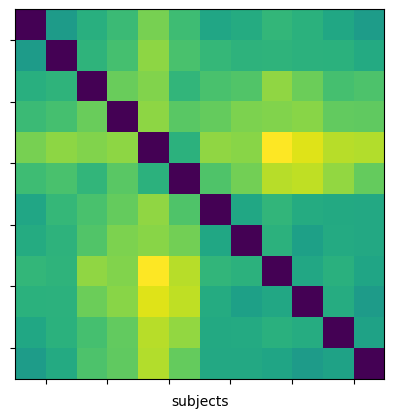

In [10]:
across = dist_alpha_0[np.triu_indices(S_tot,2)].reshape(-1)
within_cue = dist_alpha_0[range(0,S_tot,2),range(1,S_tot,2)]
# within_session = dist_alpha_0[range(0,S_tot,3),range(2,S_tot,3)]

In [11]:
import scipy.stats as sts

t,pvalue= sts.ttest_ind(across,within_cue)
print(pvalue)
#print(sts.ttest_ind(across,within_session))

0.03890031404909079


In [12]:
across_names = np.array(dist_names)[np.triu_indices(S_tot,3)].reshape(-1)
within_cue_names = np.array(dist_names)[range(0,S_tot,3),range(1,S_tot,3)]
within_session_names = np.array(dist_names)[range(0,S_tot,3),range(2,S_tot,3)]

In [13]:
print("across",across_names)
print("within cue",within_cue_names)
#print("within session",within_session_names)


across ['cue1_0cue2_1' 'cue1_0cue1_2' 'cue1_0cue2_2' 'cue1_0cue1_3'
 'cue1_0cue2_3' 'cue1_0cue1_4' 'cue1_0cue2_4' 'cue1_0cue1_5'
 'cue1_0cue2_5' 'cue2_0cue1_2' 'cue2_0cue2_2' 'cue2_0cue1_3'
 'cue2_0cue2_3' 'cue2_0cue1_4' 'cue2_0cue2_4' 'cue2_0cue1_5'
 'cue2_0cue2_5' 'cue1_1cue2_2' 'cue1_1cue1_3' 'cue1_1cue2_3'
 'cue1_1cue1_4' 'cue1_1cue2_4' 'cue1_1cue1_5' 'cue1_1cue2_5'
 'cue2_1cue1_3' 'cue2_1cue2_3' 'cue2_1cue1_4' 'cue2_1cue2_4'
 'cue2_1cue1_5' 'cue2_1cue2_5' 'cue1_2cue2_3' 'cue1_2cue1_4'
 'cue1_2cue2_4' 'cue1_2cue1_5' 'cue1_2cue2_5' 'cue2_2cue1_4'
 'cue2_2cue2_4' 'cue2_2cue1_5' 'cue2_2cue2_5' 'cue1_3cue2_4'
 'cue1_3cue1_5' 'cue1_3cue2_5' 'cue2_3cue1_5' 'cue2_3cue2_5'
 'cue1_4cue2_5']
within cue ['cue1_0cue2_0' 'cue2_1cue1_2' 'cue1_3cue2_3' 'cue2_4cue1_5']


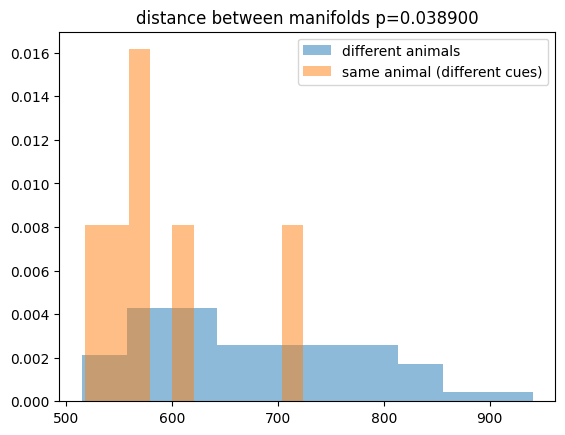

In [195]:
total_neurons = []

n_pcs = 60
pca = PCA(n_components=n_pcs)
angles = []
all_HD_common_pca = []
for i,s in enumerate(session_rotCue):
    data=loadmat(s + '/Analysis/TuningCurvesCue.mat')

    cue1 = data["meanTCcue"][:,:,0]
    cue2 = data["meanTCcue"][:,:,1]

    pca_fit = pca.fit(cue1)
    pca_cue1,pca_cue2 = pca_fit.transform(cue1), pca_fit.transform(cue2)

    angles.append(angular_distance(pca_cue1,pca_cue2))
    all_HD_common_pca.append([pca_cue1,pca_cue2])

all_HD_common_pca = np.concatenate(all_HD_common_pca)
S_tot = len(all_HD_common_pca)

In [196]:
imp.reload(utils)


angles_all = np.zeros((S_tot,S_tot))*np.nan
for i in range(len(all_HD_common_pca)):
    for j in range(i,len(all_HD_common_pca)):

        angles_all[i,j]=angles_all[j,i]=angular_distance(all_HD_common_pca[i],all_HD_common_pca[j])


In [197]:
across_angle =angles_all[np.triu_indices(S_tot,2)].reshape(-1)
within_cue_angle =angles_all[range(0,S_tot,2),range(1,S_tot,2)]


In [198]:
t,pvalue= sts.ttest_ind(across_angle,within_cue_angle)
pvalue

np.float64(0.017318632013321476)

98.97568465532314


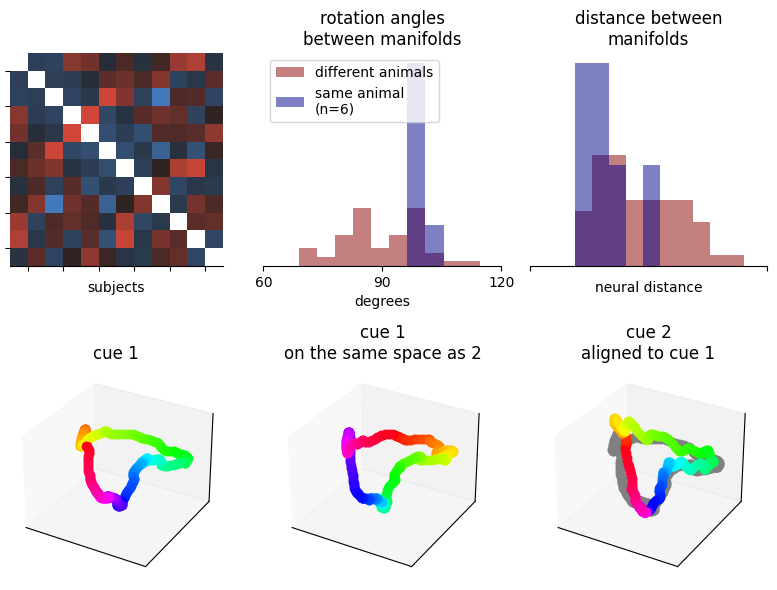

In [199]:
pca_cue1 = all_HD_common_pca[0]
pca_cue2 = all_HD_common_pca[1]

def plot_cue(pca_cue,color=None,ax=None):
    if color is None:
        colors = sns.color_palette("hsv", 360)
    else:
        colors = [color]*360

    [ax.plot(pca_cue[p,0],pca_cue[p,1],pca_cue[p,2],"o",color=colors[p]) for p in range(360)]
    

    #z=ax.get_zlim()[0]
    #ax.plot(pca_cue1[:,0],pca_cue1[:,1],z*np.ones_like(pca_cue1[:,0]),color='gray',lw=5,alpha=0.25) 


    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])




fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(231)
# divergent colormap
hue_neg, hue_pos = 250, 15

cmap = sns.diverging_palette(hue_pos, hue_neg, center="dark", as_cmap=True)
angles_all[np.diag_indices(S_tot)]=np.nan
plt.imshow(angles_all-90,cmap=cmap)
plt.xticks(np.arange(0.5,S_tot,2),[])
plt.yticks(np.arange(0.5,S_tot,2),[])
plt.xlabel('subjects')

ax = fig.add_subplot(232)
x=plt.hist(across_angle,alpha=0.5,density=True,bins=10,label='different animals',color='darkred')
plt.hist(within_cue_angle,alpha=0.5,density=True,bins=x[1],label='same animal\n(n=6)',color='darkblue')
plt.title("rotation angles\nbetween manifolds")
plt.legend(loc='upper left')
#sns.despine(left=True)
plt.yticks([])
plt.xticks(np.radians([60,90,120]),[60,90,120])
plt.xlabel("degrees")

ax = fig.add_subplot(233)
x=plt.hist(across,alpha=0.5,density=True,bins=10,label='different animals',color='darkred')
plt.hist(within_cue,alpha=0.5,density=True,bins=x[1],label='same animal\n(n=6)',color='darkblue')
plt.title('distance between\nmanifolds')
#plt.legend()
sns.despine(left=True)
plt.yticks([])
plt.xticks([plt.xticks()[0][0],plt.xticks()[0][-1]],[])
plt.xlabel("neural distance")
plt.tight_layout()

ax = fig.add_subplot(234, projection='3d')
ax.set_title("cue 1")
plot_cue(pca_cue1,ax=ax)


ax = fig.add_subplot(235, projection='3d')
ax.set_title("cue 1\non the same space as 2")
plot_cue(pca_cue2,ax=ax)

ax = fig.add_subplot(236, projection='3d')
ax.set_title("cue 2\naligned to cue 1")
plot_cue(pca_cue1,ax=ax,color='gray')
plot_cue(pca_cue2 @ align(pca_cue2,pca_cue1),ax=ax)
print(np.degrees(angular_distance(pca_cue1,pca_cue2)))

plt.tight_layout()
plt.savefig('../results/rotation_cue.svg')

In [142]:
import matplotlib
matplotlib.rcParams['font.family']
from matplotlib.font_manager import findfont, FontProperties
findfont(FontProperties(family=['sans-serif']))



'/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

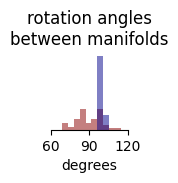

In [194]:
plt.figure(figsize=(1,1))
x=plt.hist(across_angle,alpha=0.5,density=True,bins=10,label='different animals',color='darkred')
plt.hist(within_cue_angle,alpha=0.5,density=True,bins=x[1],label='same animal\n(n=6)',color='darkblue')
plt.title("rotation angles\nbetween manifolds")
#plt.legend(loc='upper left')
#sns.despine(left=True)
plt.yticks([])
plt.xticks(np.radians([60,90,120]),[60,90,120])
plt.xlabel("degrees")
sns.despine(left=True)
plt.savefig('../results/rotation_angle.svg')